In [11]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
import rioxarray 
import os
import matplotlib as mpl
import matplotlib.colors as mcolors


In [2]:
crops = ['Corn', 'Soybean', "Wheat", "Rice"]
phases = [1,2]

In [3]:
# Read in the data
gdf_dict = {}
for crop in crops:
    for phase in phases:
        rds = rioxarray.open_rasterio(
            "../" + os.sep + "processed" + os.sep + "output" + os.sep + crop + "_phase_" + str(phase) + "_rc_mean.asc"
        )
        rds = rds.squeeze().drop("spatial_ref").drop("band")
        rds.name = "data"
        df = rds.to_dataframe().reset_index().replace(-9, np.nan).dropna()
        # Convert to geodataframe
        gdf_dict[crop+str(phase)] = df

In [4]:
def dataframe_to_geopandas(df):
    # Convert the x and y columns to longitude and latitude, respectively
    geometry = [Point(x, y) for x, y in zip(df['x'], df['y'])]
    
    # Create a GeoDataFrame from the geometry and data columns
    gdf = gpd.GeoDataFrame(df['data'], geometry=geometry)
    
    return gdf


In [5]:
# Convert the dataframes to geodataframes
gdf_dict_gpd = {}
for i in gdf_dict.keys():
    gdf_dict_gpd[i] = dataframe_to_geopandas(gdf_dict[i])

    

In [6]:
# Look at the results
gdf_dict_gpd['Corn1'].head()

,data,geometry
1838363,0.0,POINT (16.95833 54.54167)
1842682,0.0,POINT (16.87500 54.45833)
1842683,0.0,POINT (16.95833 54.45833)
1847002,0.0,POINT (16.87500 54.37500)
1847003,0.0,POINT (16.95833 54.37500)


In [7]:
gdf_dict_gpd.keys()

dict_keys(['Corn1', 'Corn2', 'Soybean1', 'Soybean2', 'Wheat1', 'Wheat2', 'Rice1', 'Rice2'])

In [8]:
# Read in the country borders
countries = gpd.read_file("../" + os.sep + "spatial_data" + os. sep +"countries" + os.sep + "World_Countries__Generalized_.shp")
countries


,FID,COUNTRY,ISO,COUNTRYAFF,AFF_ISO,SHAPE_Leng,SHAPE_Area,geometry
0,1,American Samoa,AS,United States,US,0.600124,0.013720,"POLYGON ((-170.74390 -14.37555, -170.74942 -14..."
1,2,United States Minor Outlying Islands,UM,United States,US,0.480216,0.003216,"MULTIPOLYGON (((-160.02114 -0.39805, -160.0281..."
2,3,Cook Islands,CK,New Zealand,NZ,0.980664,0.013073,"MULTIPOLYGON (((-159.74698 -21.25667, -159.793..."
3,4,French Polynesia,PF,France,FR,3.930211,0.175332,"MULTIPOLYGON (((-149.17920 -17.87084, -149.258..."
4,5,Niue,NU,New Zealand,NZ,0.541413,0.021414,"POLYGON ((-169.89389 -19.14556, -169.93088 -19..."
...,...,...,...,...,...,...,...,...
244,245,Northern Mariana Islands,MP,United States,US,0.908853,0.019927,"MULTIPOLYGON (((145.73468 15.08722, 145.72830 ..."
245,246,Palau,PW,Palau,PW,1.105323,0.031136,"MULTIPOLYGON (((134.53137 7.35444, 134.52234 7..."
246,247,Russian Federation,RU,Russian Federation,RU,1536.287150,2931.526082,"MULTIPOLYGON (((-179.99999 68.98010, -179.9580..."
247,248,Spain,ES,Spain,ES,51.724956,52.915449,"MULTIPOLYGON (((-2.91472 35.27361, -2.93924 35..."


In [9]:
oceans = gpd.read_file("../" + os.sep + "spatial_data" + os. sep + "oceans" + os.sep + "ne_10m_ocean.shp")
oceans

,featurecla,scalerank,min_zoom,geometry
0,Ocean,0,0,"MULTIPOLYGON (((59.91603 -67.40049, 59.67856 -..."


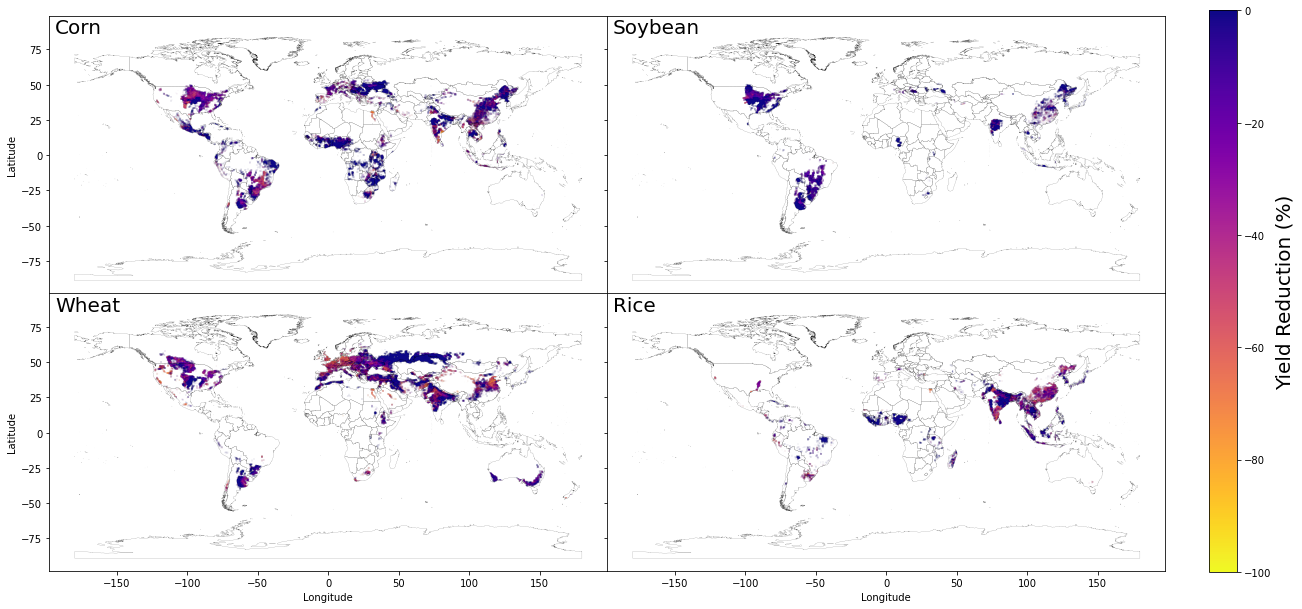

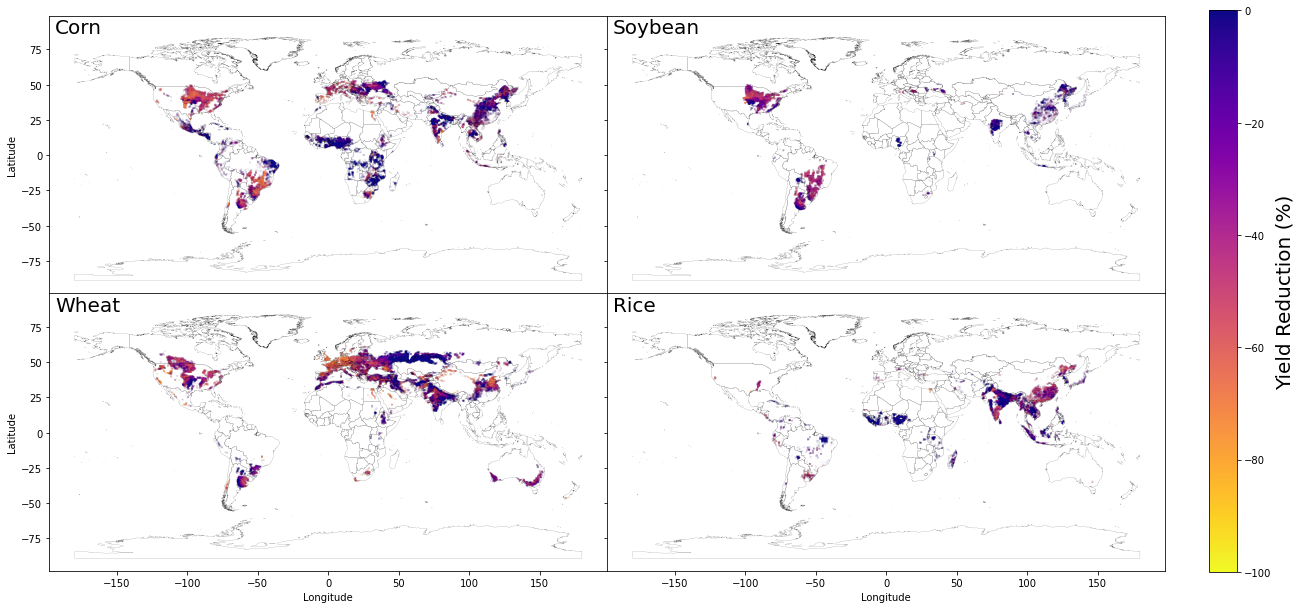

In [12]:
def plot_map(gdf_dict_gpd, crops, countries, oceans, phase):
    # Plot the geodataframes in a 2x2 grid
    # The color of the points is determined by the class they belong
    # The first plot in the right column has the title "Phase 1"
    # The second plot in the right column has the title "Phase 2"
    # All other plots don't have a title
    fig, ax = plt.subplots(2, 2, figsize=(20,12), sharex=True, sharey=True)
    ax = ax.flatten()
    for i, crop in enumerate(crops):
        gdf_dict_gpd[crop+phase].plot(
            ax=ax[i],
            column="data",
            cmap="plasma_r",
            legend=False,
            marker=",",
            markersize=0.5,
            alpha=0.01,
            vmin=-1,
            vmax=0,
        )
        oceans.plot(ax=ax[i], color="white", edgecolor="white", linewidth=0.1)
        countries.plot(ax=ax[i], color="none", edgecolor="black", linewidth=0.1)
        # Write the name of the crop in the top left corner of the plot
        ax[i].text(
            0.01,
            0.99,
            crop,
            horizontalalignment="left",
            verticalalignment="top",
            transform=ax[i].transAxes,
            fontsize=20,
        )
        if i == 0 or i == 2:
            ax[i].set_ylabel("Latitude")
        if i == 2 or i == 3:
            ax[i].set_xlabel("Longitude")


    # Add a colorbar to the right of the plot
    norm = mcolors.Normalize(vmin=-100, vmax=0)
    cax = fig.add_axes([0.93, 0.18, 0.02, 0.65])  # [left, bottom, width, height]
    cb = mpl.colorbar.ColorbarBase(cax, cmap="plasma_r", norm=norm)
    cb.set_label("Yield Reduction (%)", fontsize=20)

    plt.subplots_adjust(wspace=0, hspace=-0.26)
    plt.savefig("../" + os.sep + "reports" + os.sep + "figures" + os.sep + 'LoI'+phase+'.png', dpi=500, bbox_inches='tight')
plot_map(gdf_dict_gpd, crops, countries, oceans, "1")
plot_map(gdf_dict_gpd, crops, countries, oceans, "2")


